## **ResNet-101 CNN Model**

### **1. Import the necessary libraries**


In [7]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [8]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Load and Preprocess Data**


In [9]:
# Set paths to your dataset
train_dir = "./DATASETS/resized_dataset_256/train"
val_dir = "./DATASETS/resized_dataset_256/val"
test_dir = "./DATASETS/resized_dataset_256/test"

# Define image size and batch size
img_size = (256, 256)
batch_size = 6

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Evaluate on test set
test_generator = valid_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=12,
    class_mode="categorical",
    shuffle=False,
)

Found 48 images belonging to 4 classes.


### **4. Building ResNet-101 Model**


In [10]:
def create_efficientnetb7_model(learning_rate=0.001, dropout_rate=0.0, dense_units=128):
    # Load pre-trained ResNet101 model without top layers
    base_model = EfficientNetB7(
        weights="imagenet", include_top=False, input_shape=(256, 256, 3)
    )

    # Freeze initial layers to keep pre-trained weights unchanged
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for MRI classification task
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation="relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **5. Train the Model**


In [11]:
# Define parameter grid
param_grid = {
    "learning_rate": [0.01, 0.001, 0.0001],
    "dropout_rate": [0.0, 0.2, 0.5],
    "dense_units": [128, 256, 512],
}

# # Define parameter grid
# param_grid = {
#     "learning_rate": [0.001],
#     "dense_units": [512],
#     "dropout_rate": [0.5],
# }

# Create combinations of parameters
grid = list(ParameterGrid(param_grid))

# Initialize variables to keep track of the best model
best_params = None
best_model = None
best_history = None
best_accuracy = 0.0
best_loss = 0.0

# Iterate over parameter combinations
for params in grid:
    # Print current parameters
    print(f"Parameters: {params}")

    # Create model with current parameters
    model = create_efficientnetb7_model(
        learning_rate=params["learning_rate"],
        dropout_rate=params["dropout_rate"],
        dense_units=params["dense_units"],
    )

    # Set up data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
    )

    valid_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
    )

    # # Define callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=valid_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=valid_generator.samples // valid_generator.batch_size,
        callbacks=[early_stopping],
    )

    # Retrieve validation accuracy from history
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    # Check if current model is the best one based on validation accuracy
    if val_accuracy > best_accuracy:
        print(f"New best model found: Validation Accuracy {val_accuracy}")
        best_accuracy = val_accuracy
        best_params = params
        best_history = history.history
        best_model = model
        best_loss = val_loss

# Save the best model
best_model.save("efficientnetb7_model.h5")

# Print and save best results
print(f"Best Parameters: {best_params}")
print(f"Val Accuracy: {best_accuracy}")
print(f"Val Loss: {best_loss}")

Parameters: {'dense_units': 128, 'dropout_rate': 0.0, 'learning_rate': 0.01}
Found 336 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'model_5/block2a_expand_bn/FusedBatchNormV3' defined at (most recent call last):
    File "c:\Users\xiang\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\xiang\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\xiang\AppData\Local\Temp\ipykernel_37116\3725128587.py", line 58, in <module>
      history = model.fit(
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\xiang\miniconda3\envs\tf\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_5/block2a_expand_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[6,128,128,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_5/block2a_expand_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_372343]

### **6. Evaluate and Visualize Results**


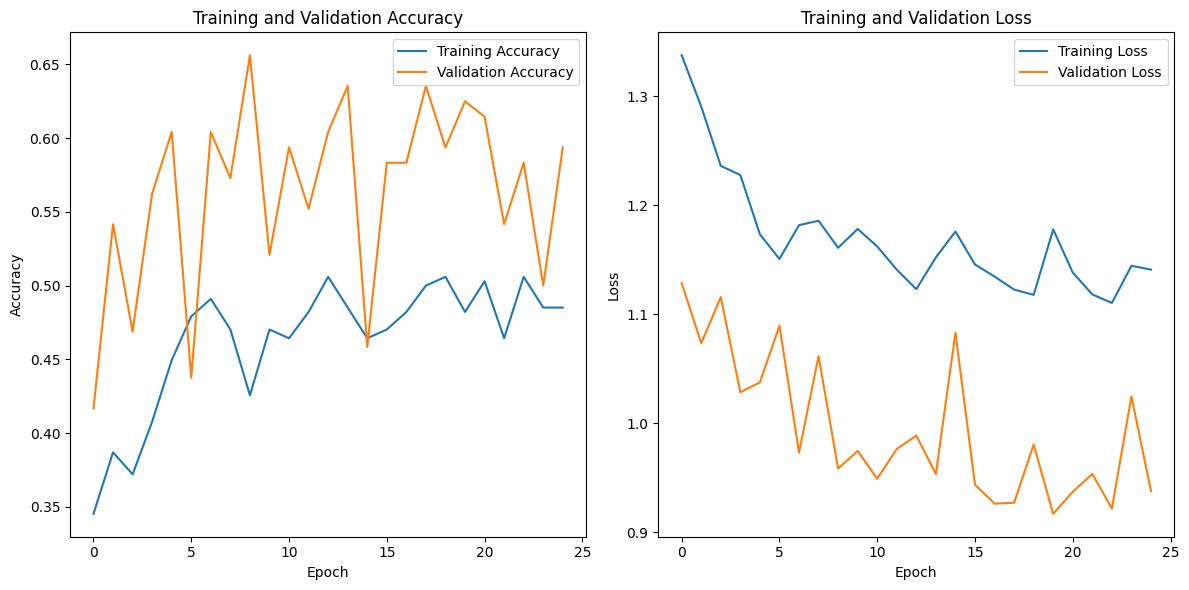

4/4 [==============================] - 1s 168ms/step - loss: 1.1763 - accuracy: 0.4792
Test Accuracy: 0.4792
Test Loss: 1.1763


In [ ]:
# Plot best model training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(best_history["accuracy"], label="Training Accuracy")
plt.plot(best_history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.xticks([0, 5, 10, 15, 20, 25])
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history["loss"], label="Training Loss")
plt.plot(best_history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.xticks([0, 5, 10, 15, 20, 25])
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

### **6. Evaluation on test set**


4/4 [==============================] - 2s 187ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.50      0.75      0.60        12
  meningioma       0.00      0.00      0.00        12
   pituitary       0.58      0.58      0.58        12
     notumor       0.47      0.67      0.55        12

    accuracy                           0.50        48
   macro avg       0.39      0.50      0.43        48
weighted avg       0.39      0.50      0.43        48



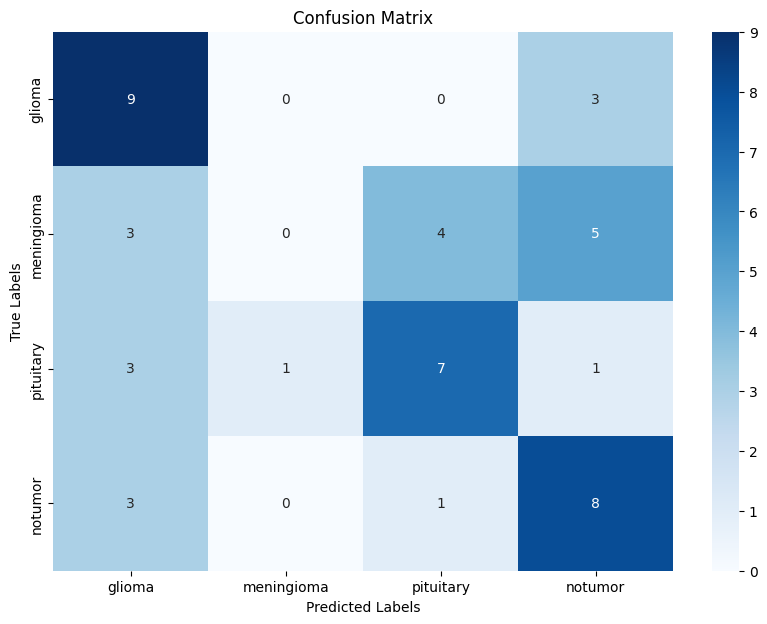

In [ ]:
# Load the best saved model
mode_name = "efficientnetb7_model.h5"
model = load_model(mode_name)

# Recompile the model with the correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # or any other optimizer you want to use
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Predict the labels for the test set
categories = ["glioma", "meningioma", "pituitary", "notumor"]
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:\n")
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()